Import needed stuff

In [1]:
import requests
import sys
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
from matplotlib import pyplot as plt
import seaborn as sns
import networkscience as ns

Downloading data by http request

In [2]:
reply = requests.get('https://data.europa.eu/euodp/data/storage/f/2020-08-11T140550/Finalised%20mobilities%20started%20in%202018%20-%20KA1.csv')
reply.encoding = 'utf-8'
csv_data = reply.text
df = pd.read_csv(StringIO(csv_data), sep=';',low_memory=False)

## Mobility of Countries
In this section we want to analyze how musch different countries are involved in the Erasmus program.

I am not sure there are enought node to have a sensible analysis of the problem.

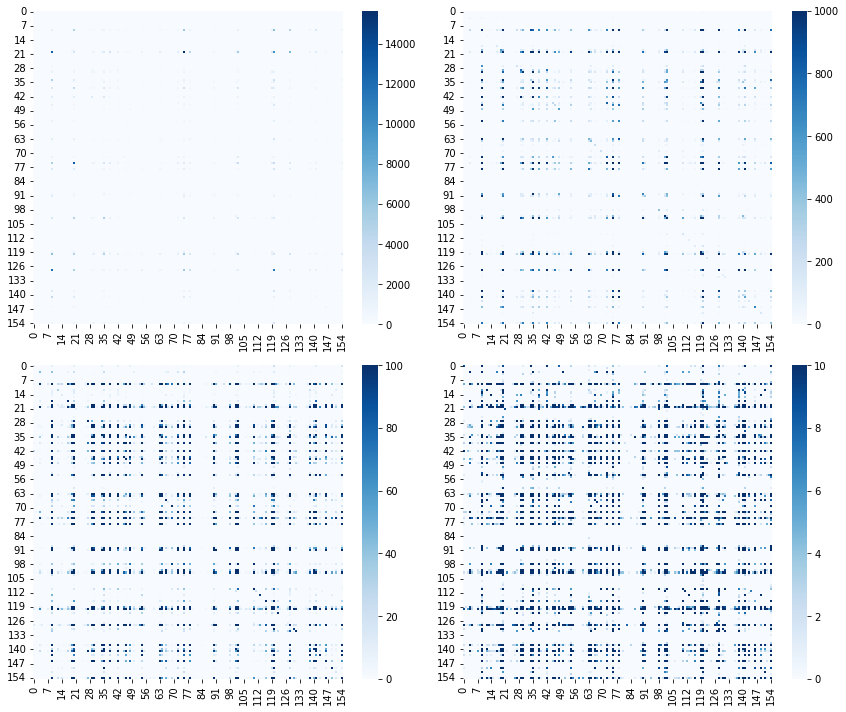

In [3]:
country_df = df[df[df.columns[10]]=='Learner']
country_df = country_df.loc[:, df.columns[np.array((14, 17, 20))]]
country_df.dropna(how='any', inplace=True)
nodes = np.array(list(set.union(set(country_df.loc[:, country_df.columns[0]]), set(country_df.loc[:, country_df.columns[1]]))))
# I don't want it to take forever
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
country_df['SendId'] = (np.array(list(map(lambda x: node_position[x], country_df['Sending Country Code']))))
country_df['RecId']= (np.array(list(map(lambda x: node_position[x], country_df['Receiving Country Code']))))
# Adjacency matrix
country_serie = country_df.groupby(['SendId', 'RecId']).sum()
row = np.array(country_serie.index.get_level_values(1).tolist())
col = np.array(country_serie.index.get_level_values(0).tolist())
val = country_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

ns.visualize_adj(adj_matrix_crs)

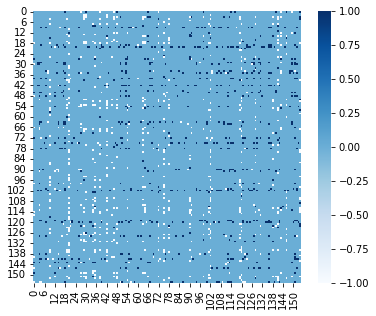

In [4]:
# I was trying to understand if it is symmetrical
matr = adj_matrix_crs.toarray()
matr[matr>1]=1
matr = matr - matr.T
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(matr, cmap="Blues", ax=ax)
plt.show()


In [5]:
country_df

,Sending Country Code,Receiving Country Code,Participants,SendId,RecId
0,PT,PL,1,38,102
1,PT,PL,1,38,102
53,AT,IE,1,154,34
54,AT,IE,1,154,34
55,AT,IE,1,154,34
...,...,...,...,...,...
688505,ES,UK,1,20,128
688506,ES,UK,1,20,128
688507,CZ,UK,1,42,128
688508,FR,UK,1,9,128


### Degree distribution

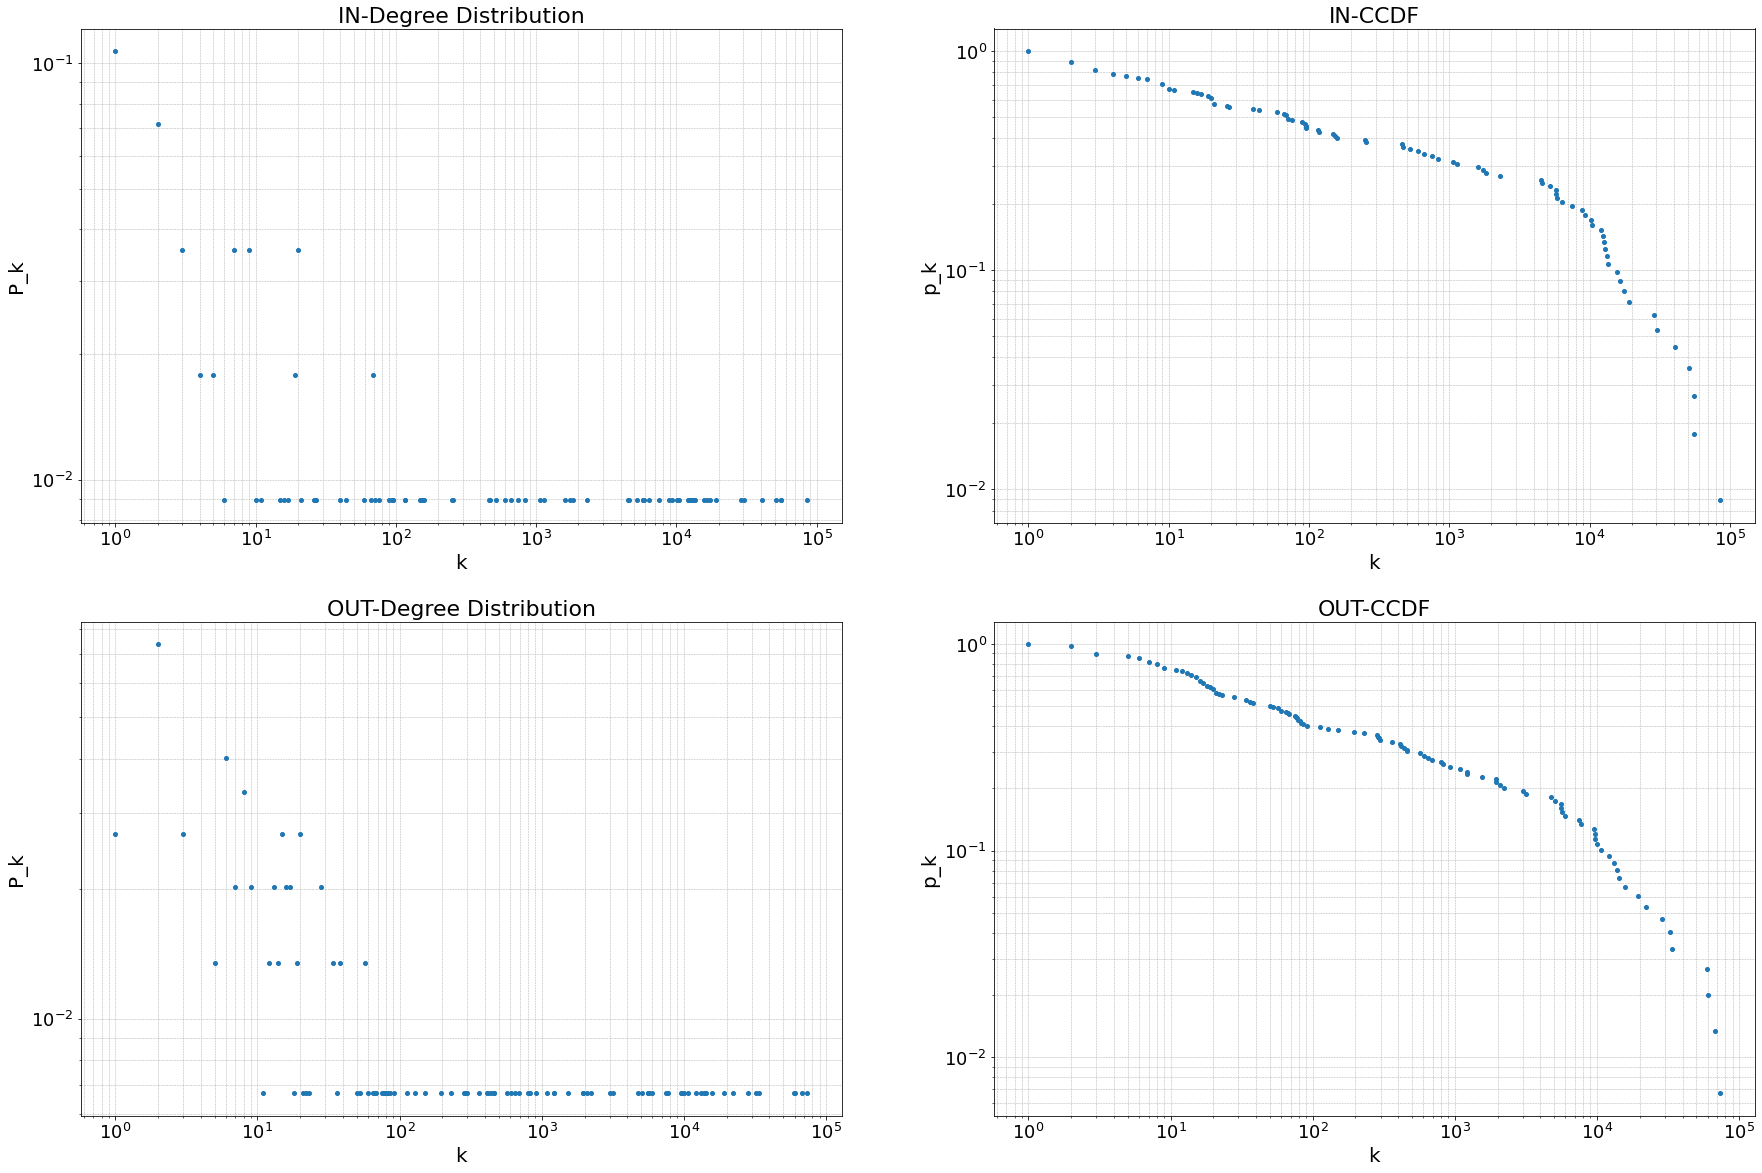

Top 10 for in degree


,Nodes,in degree
20,ES,85255
128,UK,55556
120,DE,55489
75,IT,50912
9,FR,40840
102,PL,30154
38,PT,28984
78,NL,19163
34,IE,17474
42,CZ,16559


Top 10 for out degree


,Nodes,out degree
9,FR,73481
120,DE,67772
75,IT,60222
20,ES,59413
35,TR,33511
102,PL,32388
128,UK,28448
78,NL,22090
119,RO,19294
38,PT,15750


In [6]:
scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
ns.display_top_n(scores, 10, 'in degree')
ns.display_top_n(scores, 10, 'out degree')

### HITS (NetworkX)

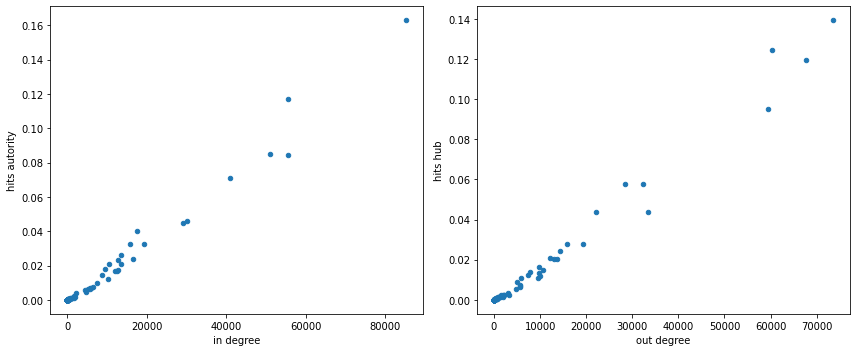

Top 10 for hits hub


,Nodes,hits hub
9,FR,0.139283
75,IT,0.124679
120,DE,0.119749
20,ES,0.094932
128,UK,0.057723
102,PL,0.057705
78,NL,0.043805
35,TR,0.043587
119,RO,0.027973
38,PT,0.027626


Top 10 for hits autority


,Nodes,hits autority
20,ES,0.162843
128,UK,0.117227
75,IT,0.085113
120,DE,0.084523
9,FR,0.071154
102,PL,0.046151
38,PT,0.044684
34,IE,0.040060
141,BE,0.032396
78,NL,0.032326


In [7]:
df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'hits hub')
ns.display_top_n(scores, 10, 'hits autority')

### PageRank (NetworkX)

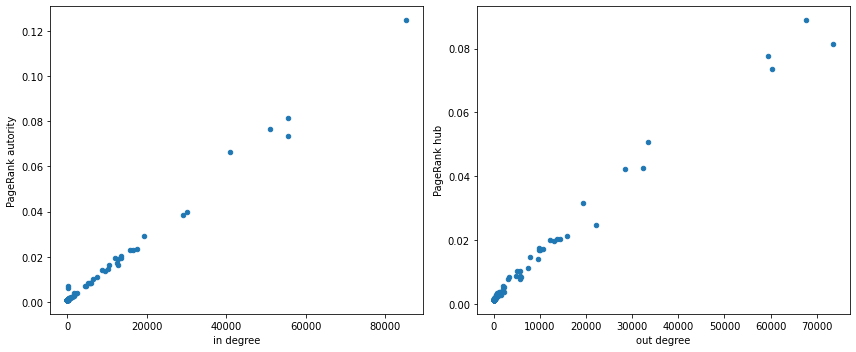

Top 10 for PageRank hub


,Nodes,PageRank hub
120,DE,0.088870
9,FR,0.081390
20,ES,0.077764
75,IT,0.073692
35,TR,0.050792
102,PL,0.042699
128,UK,0.042150
119,RO,0.031626
78,NL,0.024640
38,PT,0.021385


Top 10 for PageRank autority


,Nodes,PageRank autority
20,ES,0.124574
120,DE,0.081602
75,IT,0.076687
128,UK,0.073659
9,FR,0.066544
102,PL,0.040025
38,PT,0.038717
78,NL,0.029240
34,IE,0.023405
42,CZ,0.023160


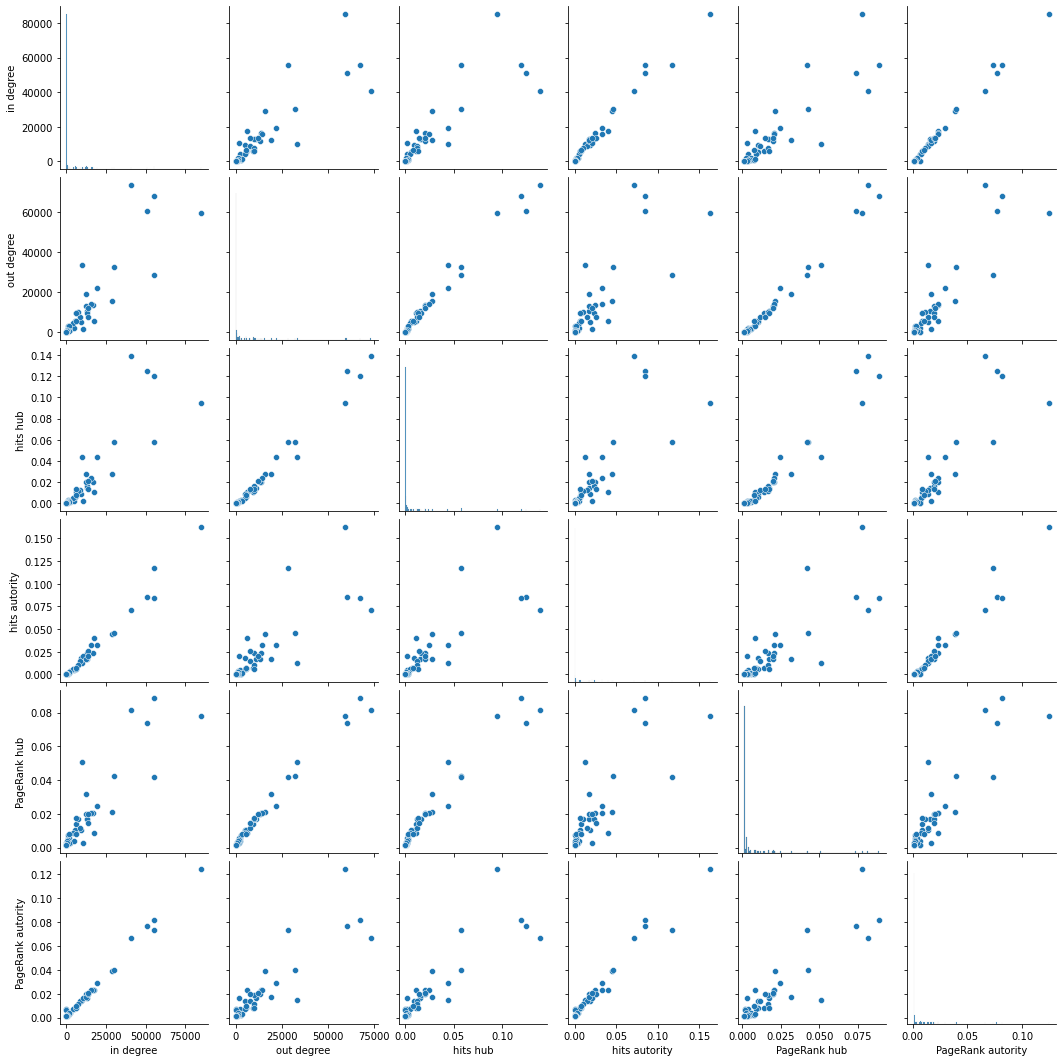

In [8]:
df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'PageRank hub')
ns.display_top_n(scores, 10, 'PageRank autority')

sns.pairplot(scores)
plt.show()

### Assortativity
We have to check if this disassortativity is due to structural reason, because it looks weird. It is almost the opposit of what we saw for the complete network.

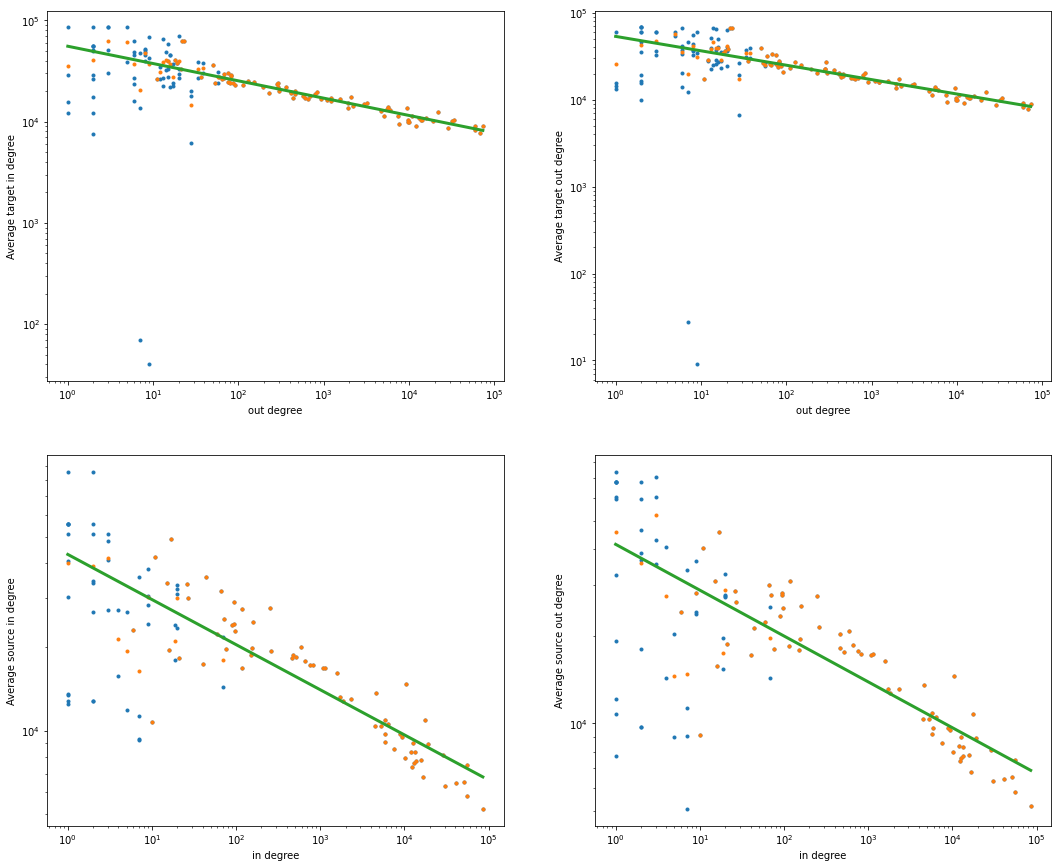

(-0.1709131474314809,
 -0.16566416781192514,
 -0.16258008251223896,
 -0.15802291954725187)

In [9]:
edges = country_df[['Sending Country Code','Receiving Country Code']].copy()
edges.rename({'Sending Country Code': 'source', 'Receiving Country Code':'target'},axis=1, inplace=True)
ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True)